<a href="https://colab.research.google.com/github/peanutjh/FinalProject/blob/%ED%98%84%EA%B2%BD/08_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순차적 데이터(sequential data)
- 순서를 가진 데이터
    - 순서가 중요
    - 가변적 길이
    - 텍스트, 음성, 동영상, 기온, 가격 등


# 순환신경망(Recurrent Neural Networks)
- 이전 단계의 처리 결과가 다음 단계에 입력이 되는 형태의 신경망
- 순환 신경망 안에 은닉층을 cell 이라고 한다.

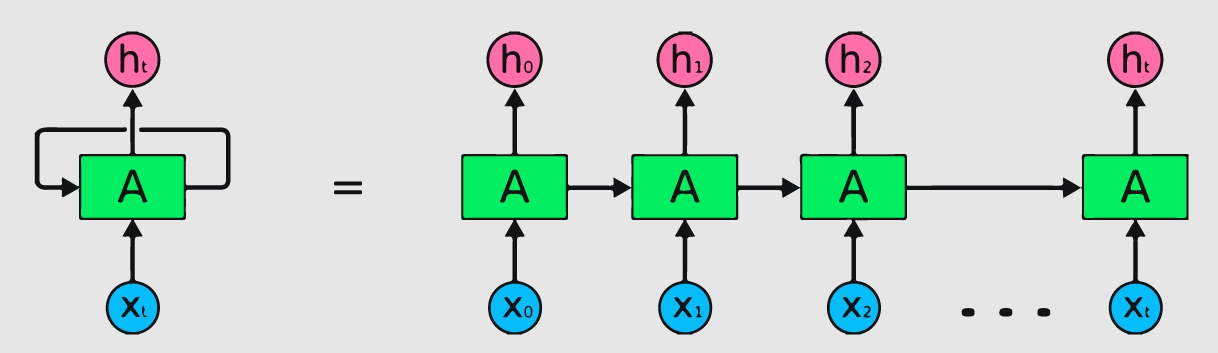

$$
h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})
$$


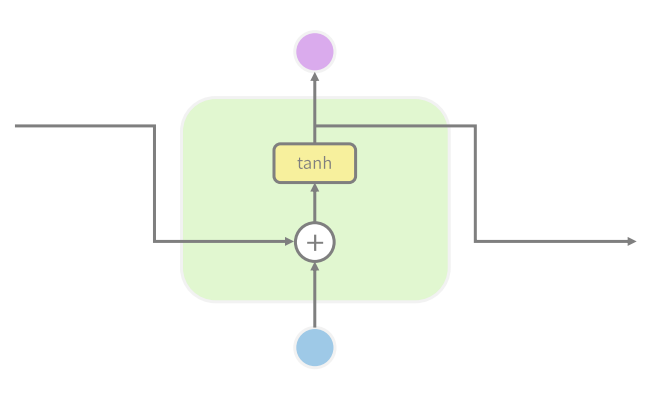

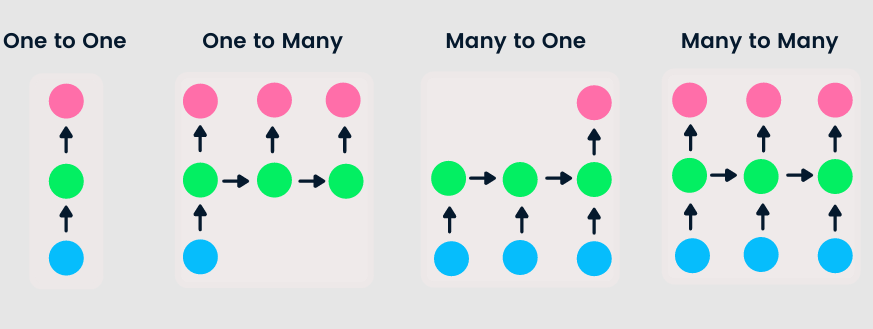

# Vanilla RNN 문제점
- 사라지는 경사
- 장기 의존 관계를 잘 학습할 수 없음


# LSTM(Long Short Term Memory)
- 순환신경망의 사라지는 경사 문제를 해결
- LSTM의 핵심은 cell state

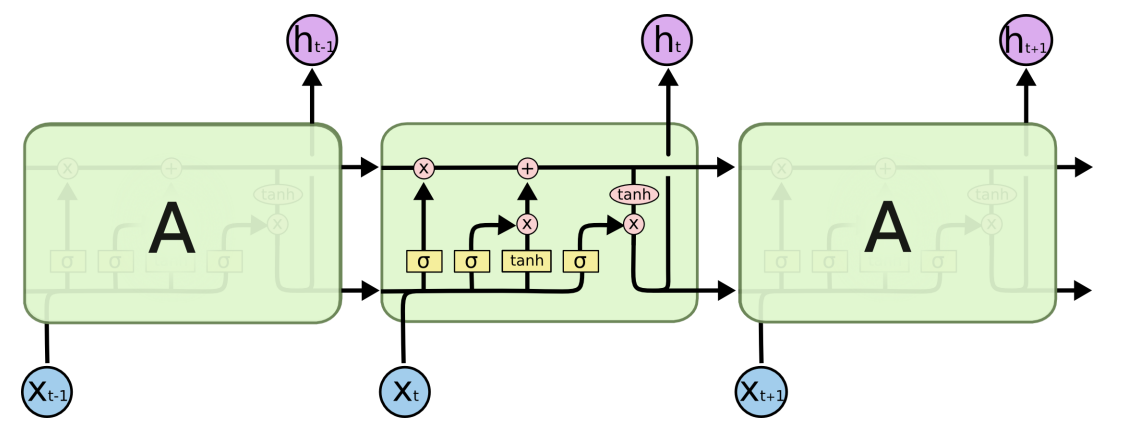

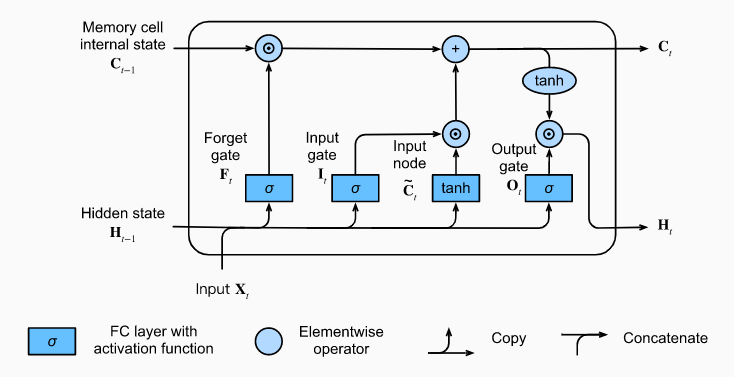

### forget gate
- 과거 정보를 얼마나 잊을지에 대한 단계
$$
\begin{split}\begin{aligned}
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f)
\end{aligned}\end{split}
$$




## input gate
- 현재 정보를 얼마나 기억할 것인지에 대한 단계
$$
\begin{split}\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i)
\end{aligned}\end{split}
$$
$$
\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c)
$$


## output gate
- 다음 cell로 전달되는 output(hidden state)을 구하는 단계
$$
\begin{split}\begin{aligned}
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o)
\end{aligned}\end{split}
$$


# GRU(Gated Recurrent Unit)
- LSTM 을 간소화
- 은닉상태만을 사용
- reset gate
  - 이전 hidden sate의 정보를 얼마나 잊을 지를 결정하는 Gate
- update gate
  - 현재 셀에 현재 정보를 얼마만큼 반영할 지를 결정하는 Gate

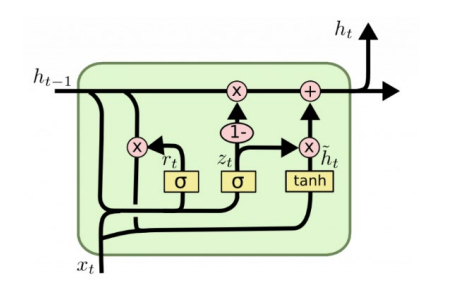

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import random
import os

In [ ]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
import pandas_datareader.data as web

In [ ]:
df = web.DataReader('005930', 'naver', start='2022-01-01', end='2022-12-31')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-01-03,79400,79800,78200,78600,13502112
2022-01-04,78800,79200,78300,78700,12427416
2022-01-05,78800,79000,76400,77400,25470640
2022-01-06,76700,77600,76600,76900,12931954
2022-01-07,78100,78400,77400,78300,15163757


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2022-01-03 to 2022-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    246 non-null    object
 1   High    246 non-null    object
 2   Low     246 non-null    object
 3   Close   246 non-null    object
 4   Volume  246 non-null    object
dtypes: object(5)
memory usage: 11.5+ KB


In [ ]:
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2022-01-03 to 2022-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    246 non-null    int64
 1   High    246 non-null    int64
 2   Low     246 non-null    int64
 3   Close   246 non-null    int64
 4   Volume  246 non-null    int64
dtypes: int64(5)
memory usage: 11.5 KB


In [ ]:
df.head(20)

,Open,High,Low,Close,Volume
Date,,,,,
2022-01-03,79400,79800,78200,78600,13502112
2022-01-04,78800,79200,78300,78700,12427416
2022-01-05,78800,79000,76400,77400,25470640
2022-01-06,76700,77600,76600,76900,12931954
2022-01-07,78100,78400,77400,78300,15163757
2022-01-10,78100,78100,77100,78000,9947422
2022-01-11,78400,79000,78000,78900,13221123
2022-01-12,79500,79600,78600,78900,11000502
2022-01-13,79300,79300,77900,77900,13889401


- ndarray 로 변경

In [ ]:
data = df.to_numpy()
data

array([[   79400,    79800,    78200,    78600, 13502112],
       [   78800,    79200,    78300,    78700, 12427416],
       [   78800,    79000,    76400,    77400, 25470640],
       ...,
       [   58000,    58400,    57900,    58100, 10667027],
       [   57600,    57600,    56400,    56600, 14665410],
       [   56000,    56200,    55300,    55300, 11295935]])

- minmax scaling 하기

In [ ]:
mins = data.min(axis=0)
sizes = data.max(axis=0) - mins

In [ ]:
sizes

array([   27200,    26200,    26800,    26300, 32175455])

In [ ]:
train = (data - mins) / sizes
train

array([[0.99632353, 1.        , 0.98507463, 0.98859316, 0.24037609],
       [0.97426471, 0.97709924, 0.98880597, 0.99239544, 0.20697498],
       [0.97426471, 0.96946565, 0.91791045, 0.94296578, 0.61235305],
       ...,
       [0.20955882, 0.18320611, 0.22761194, 0.20912548, 0.1522628 ],
       [0.19485294, 0.15267176, 0.17164179, 0.15209125, 0.27653091],
       [0.13602941, 0.09923664, 0.13059701, 0.1026616 , 0.17180901]])

In [ ]:
# 복원
train * sizes + mins

array([[   79400.,    79800.,    78200.,    78600., 13502112.],
       [   78800.,    79200.,    78300.,    78700., 12427416.],
       [   78800.,    79000.,    76400.,    77400., 25470640.],
       ...,
       [   58000.,    58400.,    57900.,    58100., 10667027.],
       [   57600.,    57600.,    56400.,    56600., 14665410.],
       [   56000.,    56200.,    55300.,    55300., 11295935.]])

- 딥러닝에서 학습 가능한 시계열 학스데이터 만들기

In [ ]:
seq_len = 10
pred_len = 5
x_list = []  # 10치일의 입력데이터
y_list = []  # 5일치의 정답데이터

for i in tqdm(range(seq_len,train.shape[0]+1-pred_len)):
    x = train[i-seq_len:i]
    y = train[i:i+pred_len,3]

    x_list.append(x)
    y_list.append(y)

x_arr = np.array(x_list)
y_arr = np.array(y_list)

x_arr.shape, y_arr.shape

  0%|          | 0/232 [00:00<?, ?it/s]

((232, 10, 5), (232, 5))

In [ ]:
y_arr[-1]

array([0.20912548, 0.20152091, 0.20912548, 0.15209125, 0.1026616 ])

In [ ]:
train[-5:,3]

array([0.20912548, 0.20152091, 0.20912548, 0.15209125, 0.1026616 ])

- 스케일링하고 시계열 학습이 가능한 데이터를 만드는 함수

In [ ]:
def transform_data(data,mins,sizes,seq_len=10,pred_len=5):
    train = (data - mins) / sizes  # 스케일링

    x_list = []  # 10치일의 입력데이터
    y_list = []  # 5일치의 정답데이터

    for i in tqdm(range(seq_len,train.shape[0]+1-pred_len)):
        x = train[i-seq_len:i]
        y = train[i:i+pred_len,3]

        x_list.append(x)
        y_list.append(y)

    x_arr = np.array(x_list)
    y_arr = np.array(y_list)

    return x_arr, y_arr

In [ ]:
seq_len=10
pred_len=5
x_arr, y_arr = transform_data(data,mins,sizes,seq_len,pred_len)
x_arr.shape, y_arr.shape   # batch, seq, n_features

  0%|          | 0/232 [00:00<?, ?it/s]

((232, 10, 5), (232, 5))

In [ ]:
# 머신러닝에 넣는다고 한다면
# x_arr.reshape(x_arr.shape[0],-1).shape

# 데이터셋 클래스 만들기

In [ ]:
class FinanceDataset(torch.utils.data.Dataset):
    def __init__(self,x,y=None):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,idx):
        item = {}
        item['x'] = torch.Tensor(self.x[idx])
        if self.y is not None:
            item['y'] = torch.Tensor(self.y[idx])

        return item

In [ ]:
dt = FinanceDataset(x_arr,y_arr)
dl = torch.utils.data.DataLoader(dt,batch_size=1,shuffle=False)
batch = next(iter(dl))
batch

{'x': tensor([[[0.9963, 1.0000, 0.9851, 0.9886, 0.2404],
          [0.9743, 0.9771, 0.9888, 0.9924, 0.2070],
          [0.9743, 0.9695, 0.9179, 0.9430, 0.6124],
          [0.8971, 0.9160, 0.9254, 0.9240, 0.2227],
          [0.9485, 0.9466, 0.9552, 0.9772, 0.2920],
          [0.9485, 0.9351, 0.9440, 0.9658, 0.1299],
          [0.9596, 0.9695, 0.9776, 1.0000, 0.2316],
          [1.0000, 0.9924, 1.0000, 1.0000, 0.1626],
          [0.9926, 0.9809, 0.9739, 0.9620, 0.2524],
          [0.9338, 0.9351, 0.9440, 0.9392, 0.1345]]]),
 'y': tensor([[0.9468, 0.9278, 0.9011, 0.9087, 0.8745]])}

In [ ]:
batch['x'].shape  # batch, seq, features

torch.Size([1, 10, 5])

# LSTM Layer

- input_size : 피쳐 개수
- hidden_size : 은닉상태 h의 피쳐수
- batch_first : 입력데이터가 batch 먼저일경우 True 줄것, 기본값 False


In [ ]:
reset_seeds(SEED)
lstm_layer = torch.nn.LSTM(x_arr.shape[2],16,batch_first=False)
output, (hn,cn) = lstm_layer(batch['x'].permute(1,0,2))

output.shape  # seq, batch,features

torch.Size([10, 1, 16])

In [ ]:
# batch_first = False 라면 변환해서 넣어주어야한다.
batch['x'].permute(1,0,2).shape

torch.Size([10, 1, 5])

In [ ]:
hn.shape, cn.shape  # n_layer, batch, features

(torch.Size([1, 1, 16]), torch.Size([1, 1, 16]))

- num_layers
    - 순환 신경망 층을 여러개 쌓을 수 있다.


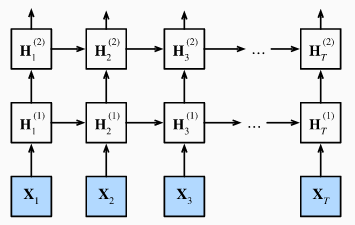

In [ ]:
reset_seeds(SEED)
lstm_layer = torch.nn.LSTM(x_arr.shape[2],16,batch_first=True,num_layers=2)
output, (hn,cn) = lstm_layer(batch['x'])

output.shape  # batch,seq, features   seq:입력길이

torch.Size([1, 10, 16])

In [ ]:
hn.shape, cn.shape  # n_layer, batch, features

(torch.Size([2, 1, 16]), torch.Size([2, 1, 16]))

In [ ]:
output[:,-1]

tensor([[ 0.0069, -0.0504, -0.1600,  0.0564, -0.1759, -0.0288,  0.0286, -0.0867,
          0.1713,  0.1276,  0.0675, -0.0608, -0.1645,  0.0101, -0.0675,  0.0200]],
       grad_fn=<SelectBackward0>)

In [ ]:
hn[-1]

tensor([[ 0.0069, -0.0504, -0.1600,  0.0564, -0.1759, -0.0288,  0.0286, -0.0867,
          0.1713,  0.1276,  0.0675, -0.0608, -0.1645,  0.0101, -0.0675,  0.0200]],
       grad_fn=<SelectBackward0>)

- bidirectional
    - 양방향으로 처리
    - 기본값이 False

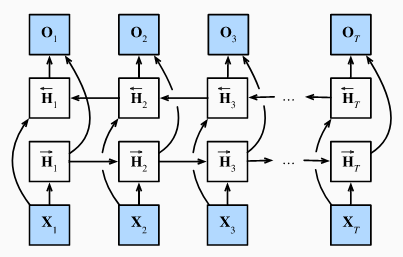

In [ ]:
lstm_later = torch.nn.LSTM(x_arr.shape[2],16,bidirectional=True, batch_first=True)
output, (hn,cn) = lstm_later(batch['x'])
output.shape   # batch, seq, fetures

torch.Size([1, 10, 32])

In [ ]:
hn.shape, cn.shape   # n_layer, batch, features

(torch.Size([2, 1, 16]), torch.Size([2, 1, 16]))

In [ ]:
output[:,-1]
# 이걸로 쓰면 안된다.

tensor([[ 0.0426, -0.1606,  0.0770, -0.1842, -0.2544,  0.2071,  0.1567,  0.0225,
         -0.2876,  0.0188,  0.0514, -0.0409, -0.2148, -0.0676, -0.2905,  0.2539,
          0.1039,  0.0595, -0.1618, -0.0921, -0.0611,  0.0845,  0.0371,  0.1040,
         -0.0570, -0.0060, -0.1596,  0.0743,  0.0884,  0.0103, -0.0617, -0.1622]],
       grad_fn=<SelectBackward0>)

In [ ]:
hn.shape

torch.Size([2, 1, 16])

In [ ]:
hn.permute(1,0,2).shape

torch.Size([1, 2, 16])

In [ ]:
hn.permute(1,0,2).flatten(1).shape

torch.Size([1, 32])

# GRU Layer


In [ ]:
gru_layer = torch.nn.GRU(x_arr.shape[2],16,batch_first=True)
output, hn = gru_layer(batch['x'])

output.shape   # batch, seq, features

torch.Size([1, 10, 16])

In [ ]:
hn.shape   # n_layer, batch, features

torch.Size([1, 1, 16])

In [ ]:
hn[-1]

tensor([[-0.1061, -0.7610, -0.2487,  0.0756, -0.3623, -0.2160, -0.3551,  0.2732,
          0.0914,  0.4342, -0.3278, -0.3894,  0.3676, -0.0361,  0.1006, -0.2256]],
       grad_fn=<SelectBackward0>)

In [ ]:
output[:,-1]

tensor([[-0.1061, -0.7610, -0.2487,  0.0756, -0.3623, -0.2160, -0.3551,  0.2732,
          0.0914,  0.4342, -0.3278, -0.3894,  0.3676, -0.0361,  0.1006, -0.2256]],
       grad_fn=<SelectBackward0>)

# 딥러닝 모델 만들기

In [ ]:
class Net(torch.nn.Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()
        self.rnn_layer = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear_layer = torch.nn.Linear(hidden_size,hidden_size//2)
        self.relu = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(hidden_size//2,5)

    def forward(self,x):
        output, (hn,cn) = self.rnn_layer(x)
        # output -> (batch,seq,features)
        # output[:,-1]
        # hn -> (n_layer, batch, features)
        x = hn[-1]   # output[:,-1] 쓰거나
        x = self.relu(x)
        return self.output_layer(x)

In [ ]:
model = Net(x_arr.shape[2],16)
model(batch['x'])

RuntimeError: ignored